In [2]:
import math
import warnings
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

warnings.filterwarnings("ignore")
#print(tf.__version__)

# Data Pre-processing

In [3]:
raw = pd.read_csv("scats-10-2006.csv")
raw.describe()

,SCATS Number,NB_LATITUDE,NB_LONGITUDE,HF VicRoads Internal,VR Internal Stat,VR Internal Loc,NB_TYPE_SURVEY,V00,V01,V02,...,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
count,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000,4192.0,4192.000000,4192.000000,4192.000000,...,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000
mean,3639.151718,-37.542437,143.985065,10234.837786,819.153626,4.252147,1.0,34.049380,30.185592,25.936307,...,76.283874,73.049380,72.192748,65.655057,61.398378,56.124761,52.262643,45.383111,40.827529,35.408158
std,805.584115,3.240889,12.429455,5579.371363,628.218870,2.194029,0.0,28.438688,26.565710,24.243348,...,37.577091,36.049374,36.669158,33.885956,33.121580,32.505183,33.070764,30.096586,30.012899,27.518453
min,970.000000,-37.867600,0.000000,-1.000000,182.000000,1.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3122.000000,-37.833120,145.036169,5887.000000,380.000000,3.000000,1.0,15.000000,12.000000,10.000000,...,51.000000,48.000000,46.000000,42.000000,37.000000,33.000000,29.000000,24.000000,20.000000,17.000000
50%,4032.000000,-37.822846,145.058038,10074.000000,650.000000,5.000000,1.0,26.000000,22.000000,18.000000,...,70.000000,67.000000,66.000000,60.000000,55.000000,50.000000,45.000000,39.000000,33.000000,28.000000
75%,4263.000000,-37.808920,145.077826,16149.000000,950.000000,7.000000,1.0,44.000000,39.000000,33.000000,...,97.000000,95.000000,93.000000,85.000000,81.000000,74.000000,68.000000,59.000000,53.000000,46.000000
max,4821.000000,0.000000,145.098850,20314.000000,2707.000000,8.000000,1.0,304.000000,252.000000,201.000000,...,334.000000,259.000000,275.000000,275.000000,231.000000,256.000000,324.000000,221.000000,279.000000,212.000000


We have 4192 values to work with.

Let's first, based on description, decide what data will be relevant:

- **SCATS Number**: ID of the intersection. We will be using this as part of our predictor.
- **Location**: Direction of the intersection. Will be hard to use this, so discard.
- **CD_MELWAY**: Essentially same as SCATS number, but in a harder to use form. Discard.
- **NB_LATITUDE, NB_LONGITUDE**: Coordinates of the intersection. Changes depending on direction (N, E, S, W, etc). For now, maybe not relevant, so discard
- **HF VicRoads Internal**: This seems to point to specific intersection exits. Could be useful?
- **VR Internal Stat/Loc**: Internal Stat seems to point to intersections, while Loc seems to point in cardinal directions as a numeral. Stat represents the same data as SCATS number, but Loc could be useful? (Similar to HF VicRoads Internal)
- **NB_TYPE_SURVEY**: Same for every entry, discard.
- **Date**: Date in dd/MM/YYYY format. As this data is only for October of 2006, the actual date might not be useful. We can try representing this as day of the week instead? This might yield more meaningful results.
- **V00 - V95**: describes times from 00:00 - 23:45, in 15-minute intervals. This is what we will use as a predictor.

In [4]:
raw.head()

,SCATS Number,Location,CD_MELWAY,NB_LATITUDE,NB_LONGITUDE,HF VicRoads Internal,VR Internal Stat,VR Internal Loc,NB_TYPE_SURVEY,Date,...,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
0,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,1/10/2006,...,114,97,97,66,81,50,59,47,29,34
1,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,2/10/2006,...,111,102,107,114,80,60,62,48,44,26
2,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,3/10/2006,...,130,132,114,86,93,90,73,57,29,40
3,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,4/10/2006,...,115,113,132,101,113,90,78,66,52,44
4,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,5/10/2006,...,171,120,116,113,99,91,61,55,49,36


For a preliminary training run, we will focus on data from only one intersection.

In [5]:
# Drop the fields we've decided to discard
df = raw.drop(["NB_LATITUDE", "NB_LONGITUDE", "CD_MELWAY", 
                 "Location", "HF VicRoads Internal", "VR Internal Stat", 
                 "VR Internal Loc", "NB_TYPE_SURVEY"], axis=1)
df.head()

,SCATS Number,Date,V00,V01,V02,V03,V04,V05,V06,V07,...,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
0,970,1/10/2006,86,83,52,58,59,44,31,37,...,114,97,97,66,81,50,59,47,29,34
1,970,2/10/2006,32,28,17,11,7,11,6,15,...,111,102,107,114,80,60,62,48,44,26
2,970,3/10/2006,26,32,21,14,10,12,13,10,...,130,132,114,86,93,90,73,57,29,40
3,970,4/10/2006,32,22,28,13,16,8,14,10,...,115,113,132,101,113,90,78,66,52,44
4,970,5/10/2006,40,39,21,11,16,9,15,15,...,171,120,116,113,99,91,61,55,49,36


Our time of day is scattered, so let's convert the V00 - V95 columns into their own rows with a new column: 'V', which will represent the 15-minute increment to predict. Date will be replaced with day of the week.

In [6]:
columns = []
for i in range(0, 96):
    if i < 10:
        columns.append("V0" + str(i))
    else:
        columns.append("V" + str(i))

In [7]:
import datetime

# parse d/MM/YYYY format to DateTime
def parse_date(date_string):
    split = date_string.split('/')

    if len(split) != 3:
        print(f"invalid date format: {date_string}")

    day = int(split[0])
    month = int(split[1])
    year = int(split[2])

    return datetime.datetime(year, month, day)

In [8]:
def append_v(n):
    if n < 10:
        column_name = "V0" + str(n)
    else:
        column_name = "V" + str(n)
        
    return column_name

In [9]:
data = []
lag = 6

for index, row in df[df['SCATS Number']==970].iterrows():
  for i in range(lag, 96):
    lag_cols = []
    for j in range(lag, 0, -1):
        lag_cols.append(append_v(i - j))

    col = append_v(i)
    #dt = parse_date(row['Date'])
    data.append([row[lag_cols].values, row[col]])

processed = pd.DataFrame(data, columns=[f'Last{lag}VFlow', 'VFlow'])

In [10]:
processed.to_csv("970_processed.csv")

# Normalization

## <span style="color:red">WARNING: EVERYTHING UNDER THIS HEADER DOESN'T WORK</span>

In [122]:
train_dataset = processed.sample(frac=0.8, random_state=0)
test_dataset = processed.drop(train_dataset.index)

In [123]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('VFlow')
test_labels = test_features.pop('VFlow')

In [36]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [37]:
normalizer.adapt(np.array(train_features).astype(np.float32))

I0000 00:00:1724673035.109167   38826 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724673035.222528   38826 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724673035.222597   38826 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724673035.224241   38826 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724673035.224310   38826 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [38]:
print(normalizer.mean.numpy())

[[  2.9407156 729.69617  ]]


In [39]:
first = np.array(train_features[:1]).astype(np.float32)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  3. 210.]]

Normalized: [[ 0.03 -1.25]]


In [124]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [VFlow]')
  plt.legend()
  plt.grid(True)

In [40]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [41]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (9446, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5 (24.00 B)

In [42]:
%%time
history = dnn_model.fit(
    train_features.astype(np.float32),
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

I0000 00:00:1724673185.506137   41379 service.cc:146] XLA service 0x7fd134007dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724673185.506170   41379 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-26 21:53:05.538252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-26 21:53:05.661656: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724673186.678379   41379 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


CPU times: user 1min 20s, sys: 22.4 s, total: 1min 43s
Wall time: 1min 15s


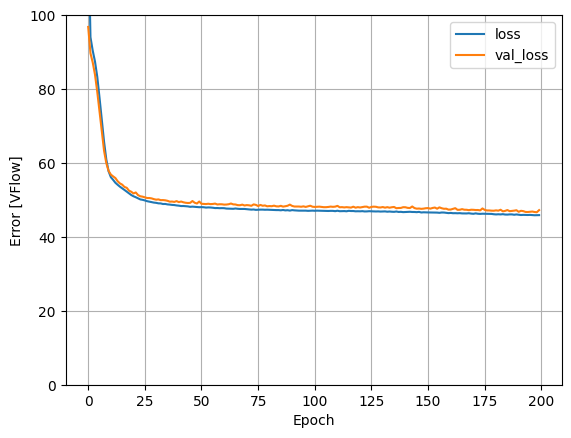

In [48]:
plot_loss(history)

In [49]:
dnn_model.evaluate(test_features.astype(np.float32), test_labels, verbose=0)

46.79032516479492

In [61]:
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,258 (51.80 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 5 (24.00 B)

 Optimizer params: 8,836 (34.52 KB)

In [79]:
test_input = np.array([3, 1365], np.float32)

In [80]:
test_input.reshape(-1, 2)

array([[   3., 1365.]], dtype=float32)

In [81]:
result = dnn_model.predict(test_input.reshape(-1, 2))
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[97.44049]]


In [125]:
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, GRU
from keras.models import Sequential

In [126]:
def get_gru(units):
    """GRU(Gated Recurrent Unit)
    Build GRU Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

In [127]:
m = get_gru([6, 64, 64, 1])

In [128]:
def train_model(model, X_train, y_train, name, config):
    """train
    train a single model.

    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number), Input data for train.
        y_train: ndarray(number), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05)

    model.save('model/' + name + '.keras')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/' + name + ' loss.csv', encoding='utf-8', index=False)

In [129]:
train_features.astype(np.float32)

ValueError: setting an array element with a sequence.

In [140]:
np.asarray(train_features).astype('float32')

ValueError: setting an array element with a sequence.

In [137]:
config = {
    "batch": 256,
    "epochs": 100
}

train_model(m, train_features.to_numpy(), train_labels, "gru", config)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).